# Experimentation with scaling copy number values

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import seaborn as sns

from speclet.data_processing import achilles as achelp
from speclet.io import data_io
from speclet.io.data_io import DataFile

In [3]:
%config InlineBackend.figure_format = "retina"
_ = gg.theme_set(gg.theme_bw())

In [4]:
real_df = achelp.read_achilles_data(data_io.data_path(DataFile.DEPMAP_CRC_SUBSAMPLE))
real_df.head(5)

,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,multiple_hits_on_gene,sgrna_target_chr,sgrna_target_pos,...,num_mutations,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,is_mutated,copy_number,lineage,primary_or_metastasis,is_male,age
0,ATAACACTGCACCTTCCAAC,LS513-311Cas9_RepA_p6_batch2,0.179367,2,chr2_157587191_-,ACVR1C,broad,True,2,157587191,...,0,NaN,NaN,NaN,False,0.964254,colorectal,primary,True,63.0
1,ATAACACTGCACCTTCCAAC,CL-11-311Cas9_RepB_p6_batch3,-0.139505,3,chr2_157587191_-,ACVR1C,broad,False,2,157587191,...,0,NaN,NaN,NaN,False,1.004888,colorectal,primary,True,NaN
2,ATAACACTGCACCTTCCAAC,SW1463-311cas9 Rep A p5_batch2,-0.192216,2,chr2_157587191_-,ACVR1C,broad,True,2,157587191,...,0,NaN,NaN,NaN,False,0.923384,colorectal,primary,False,66.0
3,ATAACACTGCACCTTCCAAC,HT29-311Cas9_RepA_p6 AVANA_batch3,0.282499,3,chr2_157587191_-,ACVR1C,broad,True,2,157587191,...,0,NaN,NaN,NaN,False,1.014253,colorectal,primary,False,44.0
4,ATAACACTGCACCTTCCAAC,KM12-311Cas9 Rep A p5_batch3,0.253698,3,chr2_157587191_-,ACVR1C,broad,True,2,157587191,...,0,NaN,NaN,NaN,False,1.048861,colorectal,primary,NaN,NaN


In [5]:
cn_vals = np.linspace(0, 10, 200)
cn_log2_p1 = np.log2(cn_vals + 1)
cn_log2_p1_z = (cn_log2_p1 - np.mean(cn_log2_p1)) / np.std(cn_log2_p1)
cn_sqrt = np.sqrt(cn_vals)

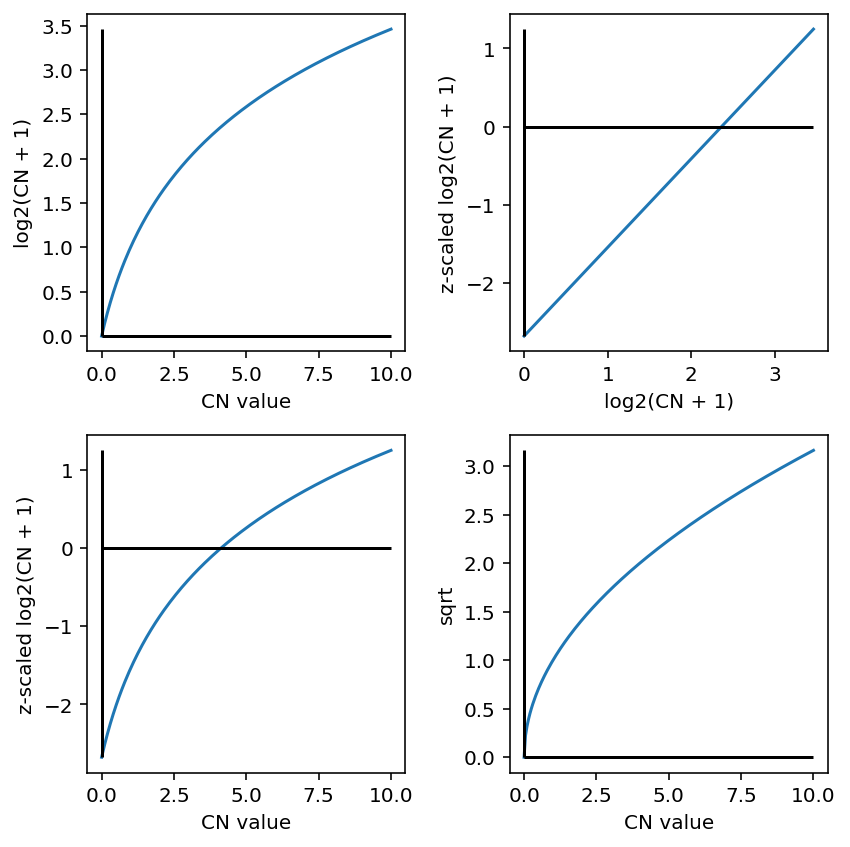

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

cn_array = np.vstack([cn_vals, cn_log2_p1, cn_log2_p1_z, cn_sqrt])
cn_array_names = ["CN value", "log2(CN + 1)", "z-scaled log2(CN + 1)", "sqrt"]

for ax, idxs in zip(axes.flatten(), ((0, 1), (1, 2), (0, 2), (0, 3))):
    a1 = cn_array[idxs[0], :]
    a2 = cn_array[idxs[1], :]
    sns.lineplot(x=a1, y=a2, ax=ax)
    ax.set_xlabel(cn_array_names[idxs[0]])
    ax.set_ylabel(cn_array_names[idxs[1]])
    ax.vlines(0, np.min(a2), np.max(a2), color="k", linestyles="-")
    ax.hlines(0, np.min(a1), np.max(a1), color="k", linestyles="-")

plt.tight_layout()
plt.show()

In [7]:
real_cn = real_df["copy_number"].values
real_cn_log2_p1 = np.log2(real_cn + 1)
real_cn_log2_p1_z = (real_cn_log2_p1 - np.mean(real_cn_log2_p1)) - np.std(
    real_cn_log2_p1
)
real_df["cn_log_z"] = real_cn_log2_p1_z

In [8]:
def histogram(df: pd.DataFrame, x: str) -> gg.ggplot:
    return (
        gg.ggplot(df, gg.aes(x=x))
        + gg.geom_histogram(bins=100)
        + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
        + gg.labs(x=x, y="count")
    )

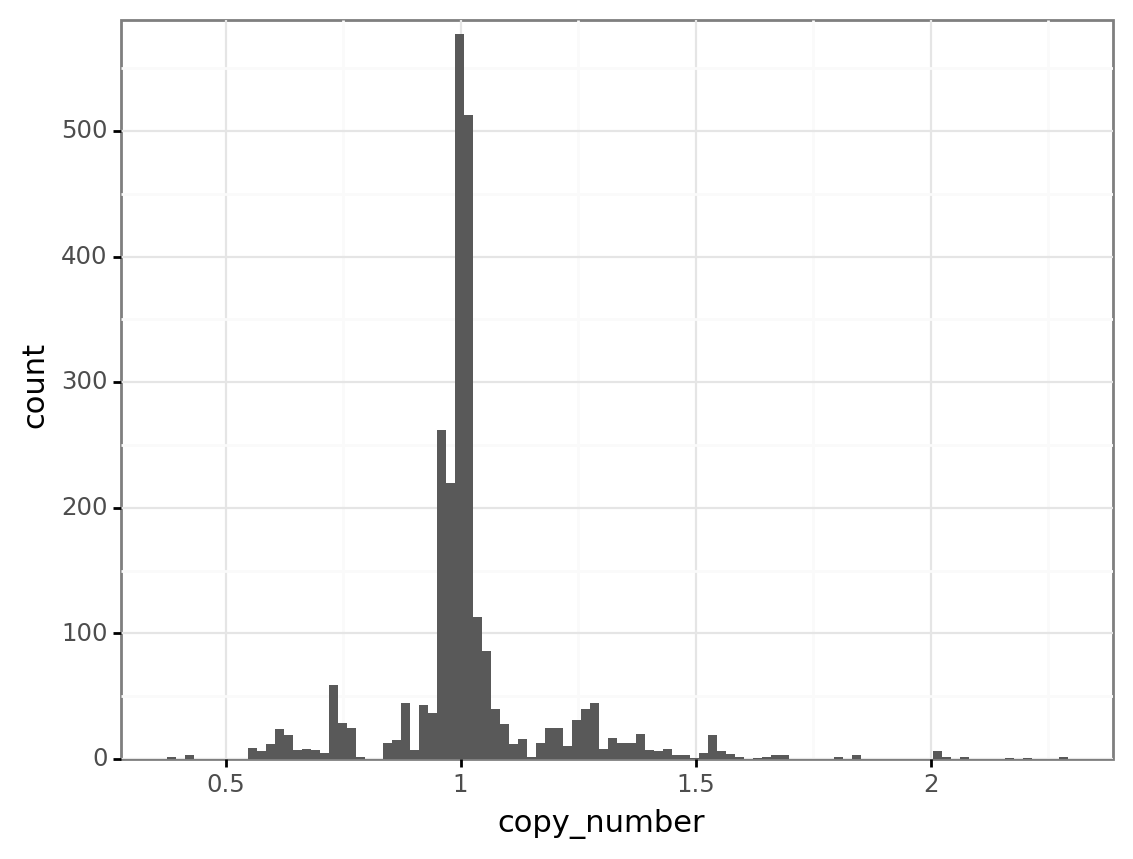

<ggplot: (348635886)>

In [9]:
histogram(real_df, "copy_number")

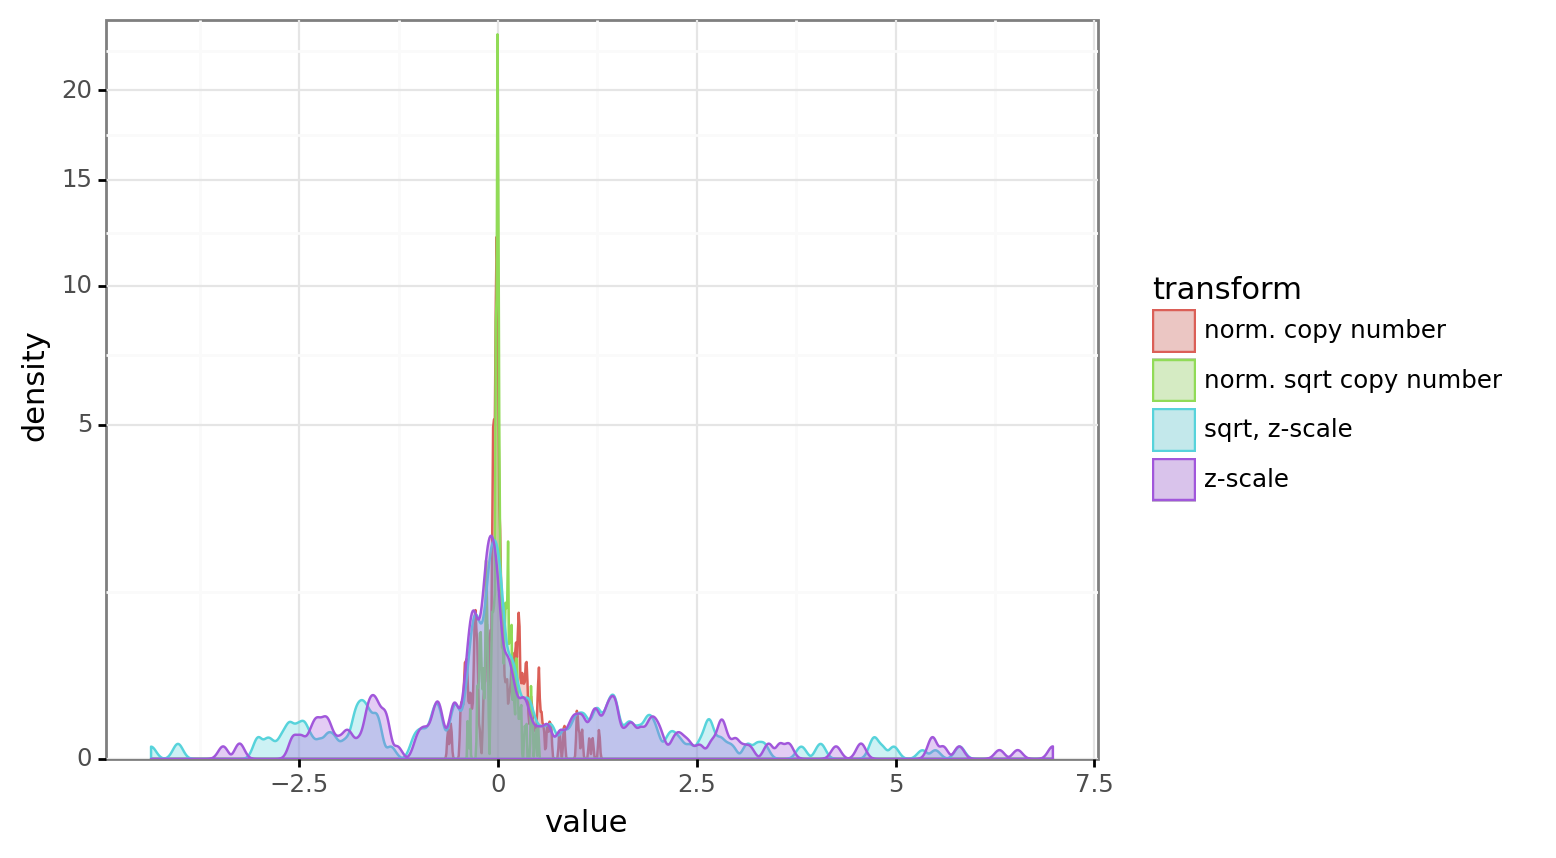

<ggplot: (348759748)>

In [10]:
real_cn_sqrt = np.sqrt(real_cn)
real_df["copy_number_z"] = (real_cn - np.mean(real_cn)) / np.std(real_cn)
real_df["copy_number_sqrt_z"] = (real_cn_sqrt - np.mean(real_cn_sqrt)) / np.std(
    real_cn_sqrt
)
real_df["copy_number_norm"] = real_cn - np.mean(real_cn)
real_df["copy_number_sqrt_norm"] = real_cn_sqrt - np.mean(real_cn_sqrt)

n = real_df.shape[0]

plot_df = pd.DataFrame(
    {
        "value": np.hstack(
            [
                real_df["copy_number_z"],
                real_df["copy_number_sqrt_z"],
                real_df["copy_number_norm"],
                real_df["copy_number_sqrt_norm"],
            ]
        ),
        "transform": np.hstack(
            [
                np.repeat("z-scale", n),
                np.repeat("sqrt, z-scale", n),
                np.repeat("norm. copy number", n),
                np.repeat("norm. sqrt copy number", n),
            ]
        ),
    }
)

(
    gg.ggplot(plot_df, gg.aes(x="value"))
    + gg.geom_density(gg.aes(fill="transform", color="transform"), alpha=0.3)
    + gg.scale_y_sqrt(expand=(0, 0, 0.02, 0))
)

In [11]:
real_df.shape

(2598, 29)

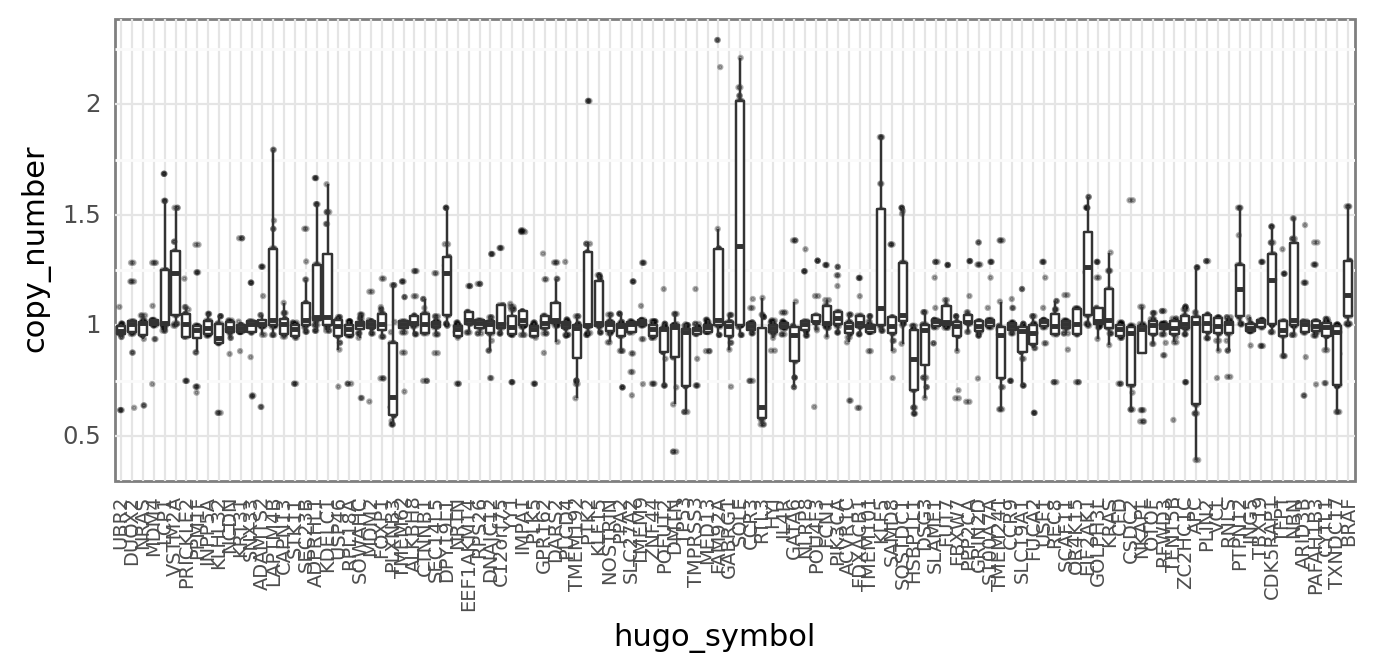

<ggplot: (348821986)>

In [12]:
(
    gg.ggplot(real_df, gg.aes(x="hugo_symbol", y="copy_number"))
    + gg.geom_jitter(width=0.2, height=0, size=0.3, alpha=0.3)
    + gg.geom_boxplot(outlier_alpha=0)
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=7),
        axis_ticks_major=gg.element_blank(),
        figure_size=(8, 3),
    )
)